In [91]:
from data_specific import *

# data
from torch.utils.data import DataLoader
import data_handling
import augmenting as A

# training
import model_saving, training, model_creating, metrics
import wandb
import torch, torch.nn as nn
from tqdm.auto import tqdm
from pathlib import Path
from evaluating import evaluate
import numpy as np

# unceratinty
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision.datasets
import torchvision.transforms as TF

In [2]:
device = torch.device(f'cuda:1')

In [10]:
data = Data.Diseases
ds_create_fn = get_ds_create_fn(data)
val_ds = ds_create_fn(trn_augm=None, is_demo=False, fold=None, only_val=True)

Using datasets:  gsa, ulb, atlas_derm, hellenic, dermnetnz
Hadling 7682 data instances


  0%|          | 0/1537 [00:00<?, ?it/s]

In [11]:
bs = 50
val_dl = DataLoader(val_ds, batch_size=bs, shuffle=False)

In [12]:
NUM_CLASSES = get_num_classes(data)
model = model_creating.create_model(NUM_CLASSES).to(device)

## загрузить модели

In [15]:
fldrs = ['logs/weights/run_20210608_113432',
         'logs/weights/run_20210608_113224',
         'logs/weights/run_20210608_113219',
         'logs/weights/run_20210608_142811',
         'logs/weights/run_20210608_140849']

In [16]:
def load_model(fldr, num_classes):
    m = model_creating.create_model(num_classes)
    src_fldr = Path('.') #'../derm-dis-morph')
    pt = list((src_fldr/fldr).iterdir())[0]
    m.load_state_dict(torch.load(pt))
    m = m.to(device).eval()
    return m

In [19]:
models = [load_model(fldr, NUM_CLASSES) for fldr in tqdm(fldrs, leave=False)]

  0%|          | 0/5 [00:00<?, ?it/s]

In [54]:
def _np(t): return t.detach().cpu().numpy()
def inference(model, dl, device):
    model.eval()
    preds, targs = [], []
    softmax = nn.Softmax(dim=1)
    for b in tqdm(dl, leave=False, desc='Inference'):
        imgs, lbls = b[0].to(device), b[1].to(device)
        with torch.no_grad(): 
            out = model(imgs)
        preds.append(_np(softmax(out)))
        targs.append(_np(lbls))
    preds = np.concatenate(preds, axis=0)
    targs = np.concatenate(targs, axis=0)
    return preds, targs
def get_entropy(probs):
    return np.sum(-probs*np.log(probs), axis=1)
def get_expected(L):
    return np.stack(L, axis=0).mean(axis=0)

In [42]:
predictions = [inference(m, val_dl, device) for m in tqdm(models)]
probs = [_[0] for _ in predictions]
labels = [_[1] for _ in predictions]

expected_probs = get_expected(probs)
entropy_of_expected = get_entropy(expected_probs)
expected_entropy = get_expected([get_entropy(_) for _ in probs])

totalU = entropy_of_expected
dataU = expected_entropy
knowU = totalU - dataU

ensemble_preds = np.argmax(expected_probs, axis=-1)
errors = (ensemble_preds != labels[0])

  0%|          | 0/5 [00:00<?, ?it/s]

Inference:   0%|          | 0/31 [00:00<?, ?it/s]

Inference:   0%|          | 0/31 [00:00<?, ?it/s]

Inference:   0%|          | 0/31 [00:00<?, ?it/s]

Inference:   0%|          | 0/31 [00:00<?, ?it/s]

Inference:   0%|          | 0/31 [00:00<?, ?it/s]

### totalU must be ~ 0

/mnt/tank/scratch/tpolevaya/miniconda3/envs/derm-dis-morph/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


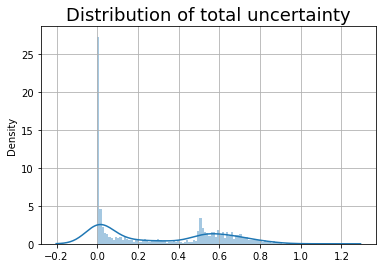

In [64]:
fig = plt.figure(figsize=(6,4))
sns.distplot(totalU, bins=100)
plt.title('Distribution of total uncertainty', fontsize=18)
plt.grid()

### more errors on totally uncertain cases

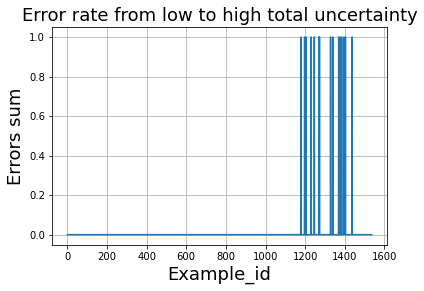

In [84]:
# total_uncertainty_order_error_cumsum = np.cumsum(errors[all_entropy_of_expected.argsort()])
errors_sorted = errors[totalU.argsort()]
fig = plt.figure(figsize=(6,4))
plt.plot(errors_sorted)
plt.xlabel('Example_id', fontsize=18)
plt.ylabel('Errors sum', fontsize=18)
plt.title("Error rate from low to high total uncertainty", fontsize=18)
plt.grid()

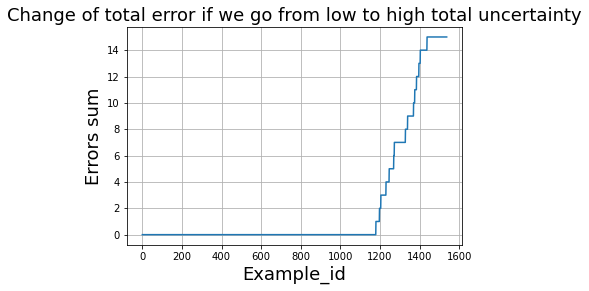

In [85]:
fig = plt.figure(figsize=(6,4))
plt.plot(np.cumsum(errors_sorted))
plt.xlabel('Example_id', fontsize=18)
plt.ylabel('Errors sum', fontsize=18)
plt.title("Change of total error if we go from low to high total uncertainty", fontsize=18)
plt.grid()

# OOD

In [111]:
root = '/mnt/tank/scratch/tpolevaya/datasets/pytorch'
_normalize = TF.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
tfm = TF.Compose([TF.ToTensor(), TF.Resize((224,224)), _normalize])
cifar_trn = torchvision.datasets.CIFAR10(root=root, train=True, transform=tfm)
cifar_test = torchvision.datasets.CIFAR10(root=root, train=False, transform=tfm)

In [117]:
ood_dl = torch.utils.data.DataLoader(cifar_test, batch_size=10, shuffle=False)

In [118]:
b = next(iter(ood_dl))

In [119]:
b[0].shape

torch.Size([10, 3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


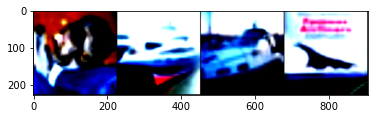

In [120]:
plt.imshow(torchvision.utils.make_grid(b[0][:4]).movedim(0, -1))

In [121]:
f_predictions = [inference(m, ood_dl, device) for m in tqdm(models)]

f_probs = [_[0] for _ in f_predictions]
f_labels = [_[1] for _ in f_predictions]

  0%|          | 0/5 [00:00<?, ?it/s]

Inference:   0%|          | 0/1000 [00:00<?, ?it/s]

Inference:   0%|          | 0/1000 [00:00<?, ?it/s]

Inference:   0%|          | 0/1000 [00:00<?, ?it/s]

Inference:   0%|          | 0/1000 [00:00<?, ?it/s]

Inference:   0%|          | 0/1000 [00:00<?, ?it/s]

In [122]:
f_expected_probs = get_expected(f_probs)
f_entropy_of_expected = get_entropy(f_expected_probs)
f_expected_entropy = get_expected([get_entropy(_) for _ in f_probs])

In [123]:
f_totalU = f_entropy_of_expected
f_dataU = f_expected_entropy
f_knowU = f_totalU - f_dataU

In [124]:
f_ensemble_preds = np.argmax(f_expected_probs, axis=-1)
f_errors = (f_ensemble_preds != f_labels[0])

### probs on in_d around 0 and 1, on OOD in between (closer to 0)

/mnt/tank/scratch/tpolevaya/miniconda3/envs/derm-dis-morph/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/mnt/tank/scratch/tpolevaya/miniconda3/envs/derm-dis-morph/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


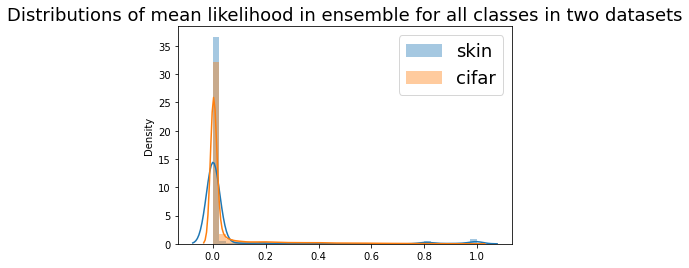

In [125]:
fig = plt.figure(figsize=(6,4))
sns.distplot(expected_probs.flatten(), label='skin', bins=40)
sns.distplot(f_expected_probs.flatten(), label='cifar', bins=40)
plt.title("Distributions of mean likelihood in ensemble for all classes in two datasets", fontsize=18)
plt.legend(fontsize=18)

### knowU on id_d ~ 0 << on OOD

/mnt/tank/scratch/tpolevaya/miniconda3/envs/derm-dis-morph/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/mnt/tank/scratch/tpolevaya/miniconda3/envs/derm-dis-morph/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


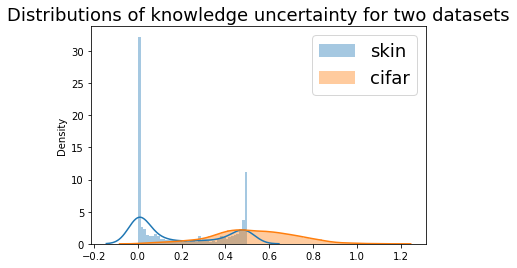

In [127]:
fig = plt.figure(figsize=(6,4))
sns.distplot(knowU, label='skin', bins=40)
sns.distplot(f_knowU, label='cifar', bins=40)
plt.title("Distributions of knowledge uncertainty for two datasets", fontsize=18)
plt.legend(fontsize=18)

### OOD detection

In [128]:
from sklearn.metrics import roc_auc_score

In [130]:
N, f_N = totalU.shape[0], f_totalU.shape[0]

In [132]:
y_true = np.zeros(N+f_N)
y_true[f_N:] = 1
knowledge_scores = np.hstack([knowU, f_knowU])
data_scores = np.hstack([dataU, f_dataU])
total_scores = np.hstack([totalU, f_totalU])

In [133]:
print(f'ROC-AUC score with knowledge uncertainty: {roc_auc_score(y_true, knowledge_scores)}')
print(f'ROC-AUC score with data uncertainty: {roc_auc_score(y_true, data_scores)}')
print(f'ROC-AUC score with total uncertainty: {roc_auc_score(y_true, total_scores)}')

ROC-AUC score with knowledge uncertainty: 0.5506279440468445
ROC-AUC score with data uncertainty: 0.5729522446324008
ROC-AUC score with total uncertainty: 0.5680045543266102
